<a href="https://colab.research.google.com/github/the-skyfishy/bmprac-assignment/blob/main/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Here is the complete code

#Start by importing necessary function libraries

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm #Import the statsmodels library

#Next read in the data

# Import datasets

# -----------------------------
# Step 0: Define years and NHANES cycles
# -----------------------------
years = ["2009", "2011", "2013", "2015", "2017"]
cycles = ["F", "G","H", "I", "J"]

# -----------------------------
# Step 1: Load All Raw Datasets
# -----------------------------
print("Loading all raw datasets...")

def load_data(file_prefix, columns):
    """Helper function to load and concatenate data across cycles."""
    urls = [f"https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/{y}/DataFiles/{file_prefix}_{c}.xpt" for y, c in zip(years, cycles)]
    df_list = []
    for url in urls:
        try:
            df = pd.read_sas(url)
            # Ensure we only select columns that actually exist in the file
            existing_cols = [col for col in columns if col in df.columns]
            df_list.append(df[existing_cols])
        except Exception as e:
            print(f"Could not load or process {url}. Error: {e}")
    return pd.concat(df_list, ignore_index=True)

df_demo = load_data("DEMO", ["SEQN","RIAGENDR", "RIDAGEYR", "RIDRETH3"])
df_bmx = load_data("BMX", ["SEQN", "SDDSRVYR","BMXBMI"])
df_bio = load_data("BIOPRO", ["SEQN", "LBXSTP"])  #Replace LBXSCR with your variable for your assignment/presentation
df_bpx = load_data("BPX", ["SEQN", "BPXSY1", "BPXSY2", "BPXSY3"])
df_bpx["BPXSY"] = df_bpx[["BPXSY1", "BPXSY2", "BPXSY3"]].median(axis=1)
df_bpx = df_bpx.drop(columns=["BPXSY1", "BPXSY2", "BPXSY3"])
df_smq = load_data("SMQ", ["SEQN", "SMQ040"]) #Do you now smoke cigarettes?

df = pd.merge(df_demo, df_bmx, on='SEQN')
df = pd.merge(df, df_bio, on='SEQN')
df = pd.merge(df, df_bpx, on='SEQN')
df = pd.merge(df, df_smq, on='SEQN')

print (df.columns.to_list())
print (df.info)
print (df.isnull().sum())

Loading all raw datasets...
['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH3', 'BMXBMI', 'LBXSTP', 'BPXSY', 'SMQ040']
<bound method DataFrame.info of            SEQN  RIAGENDR  RIDAGEYR  RIDRETH3  BMXBMI  LBXSTP  BPXSY  SMQ040
0       51624.0       1.0      34.0       NaN   32.22     7.5  114.0     3.0
1       51626.0       1.0      16.0       NaN   22.00     7.5  112.0     NaN
2       51628.0       2.0      60.0       NaN   42.39     8.2  150.0     1.0
3       51629.0       1.0      26.0       NaN   32.61     6.6  104.0     3.0
4       51630.0       2.0      49.0       NaN   30.57     7.5  116.0     1.0
...         ...       ...       ...       ...     ...     ...    ...     ...
34037  102952.0       2.0      70.0       6.0   20.00     7.4  140.0     NaN
34038  102953.0       1.0      42.0       1.0   35.80     7.5  122.0     3.0
34039  102954.0       2.0      41.0       4.0   26.10     6.5  116.0     NaN
34040  102955.0       2.0      14.0       4.0   45.60     7.5  114.0     NaN
34041  10

In [2]:


#Restrict age to 30 to 80
df = df[df["RIDAGEYR"] >= 30]

#Map age to decades
df["Age"] = pd.cut(df["RIDAGEYR"], bins=[30, 39, 49, 59, 69, 79, 89], labels=["30-39", "40-49", "50-59", "60-69", "70-79", "80 Plus"])
df.drop(columns=["RIDAGEYR"], inplace=True)



#Mapping
#Map gender
gender_map = {1: "Male", 2: "Female"}
df["RIAGENDR"] = df["RIAGENDR"].replace(gender_map)

#Map ethnicity
ethnicity_map = {1: "Mexican American",
                 2: "Other Hispanic",
                 3: "Non-Hispanic White",
                 4: "Non-Hispanic Black",
                 6: "Non-Hispanic Asian",
                 7: "Other Race - Including Multi-Racial"}
df["RIDRETH3"] = df["RIDRETH3"].replace (ethnicity_map)

#Map smoking
smoking_map = {1: "Smoke every day", 2: "Smoke some days", 3: "Non-smoker", 7: "Missing", 9: "Missing" }
df["Smoking"] = df["SMQ040"].replace(smoking_map)
df.drop(columns=["SMQ040"], inplace=True)

#Arrange df["Smoking"] so that Non-smoker is first
df["Smoking"] = pd.Categorical(df["Smoking"], categories=["Non-smoker", "Smoke every day", "Smoke some days"], ordered=True)





# Define BMI categories
bmi_labels = ["Underweight", "Normal weight", "Overweight", "Obese"]

# Apply pd.cut() with list of labels, not dictionary
df["BMI_category"] = pd.cut(df["BMXBMI"],
                            bins=[0, 18.5, 24.9, 29.9, float("inf")],
                            labels=bmi_labels)

df.drop(columns=["BMXBMI"], inplace=True)

#Arrange BMI_category so that Normal_weight is first
df["BMI_category"] = pd.Categorical(df["BMI_category"], categories=bmi_labels, ordered=True)

In [3]:
df.dropna(inplace=True)
df.drop(columns=["SEQN"], inplace=True)
# Check the columns after dropping NA and SEQN
print(df.columns)

display (df)

Index(['RIAGENDR', 'RIDRETH3', 'LBXSTP', 'BPXSY', 'Age', 'Smoking',
       'BMI_category'],
      dtype='object')


,RIAGENDR,RIDRETH3,LBXSTP,BPXSY,Age,Smoking,BMI_category
7376,Female,Non-Hispanic Black,7.6,102.0,40-49,Smoke every day,Obese
7379,Male,Non-Hispanic Asian,7.0,144.0,50-59,Smoke every day,Normal weight
7392,Male,Non-Hispanic White,8.2,112.0,50-59,Non-smoker,Overweight
7403,Female,Non-Hispanic Black,6.7,134.0,30-39,Smoke every day,Obese
7413,Female,Non-Hispanic White,7.7,124.0,30-39,Non-smoker,Overweight
...,...,...,...,...,...,...,...
34034,Male,Non-Hispanic Black,7.7,152.0,70-79,Non-smoker,Overweight
34035,Female,Non-Hispanic White,7.1,88.0,30-39,Non-smoker,Normal weight
34036,Male,Non-Hispanic White,7.3,122.0,30-39,Smoke every day,Normal weight
34038,Male,Mexican American,7.5,122.0,40-49,Non-smoker,Obese


In [4]:
#List the categorical columns
cat_cols = ["RIAGENDR", "RIDRETH3", "Smoking", "BMI_category", "Age"]
num_cols = ["BPXSY", "LBXSTP"]

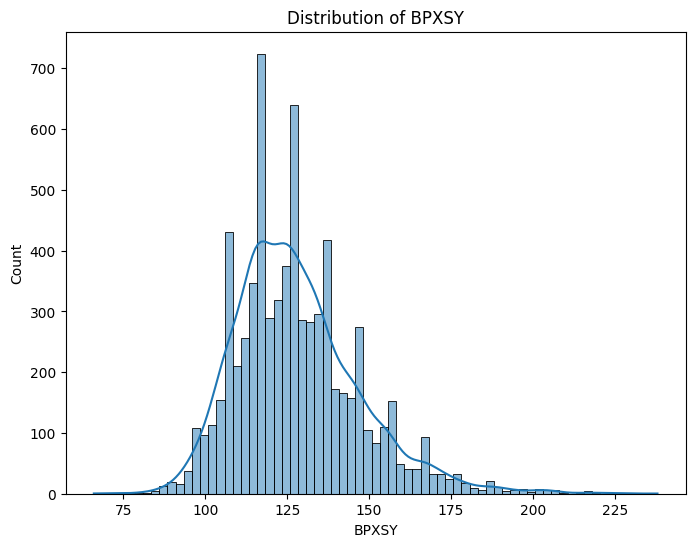

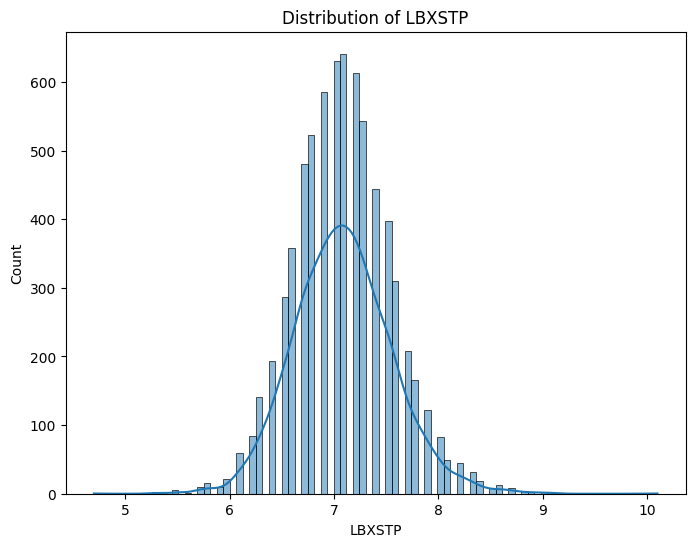

In [5]:
#Prepare histograms for the numerical columns
import matplotlib.pyplot as plt
import seaborn as sns
for col in num_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)

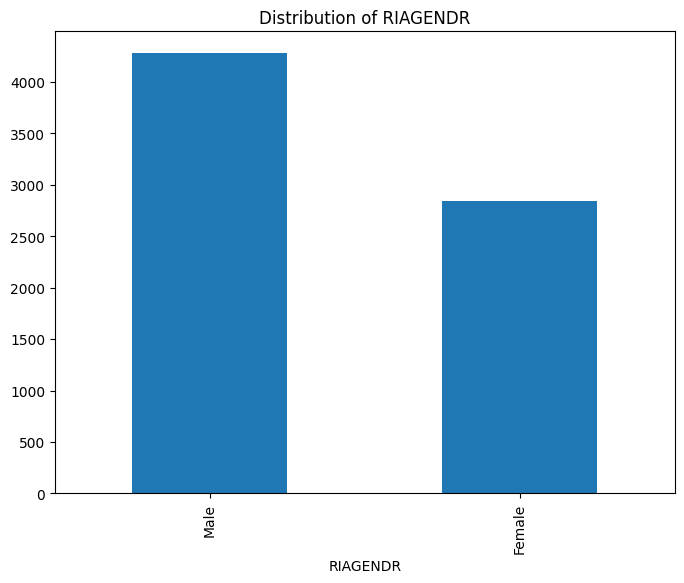

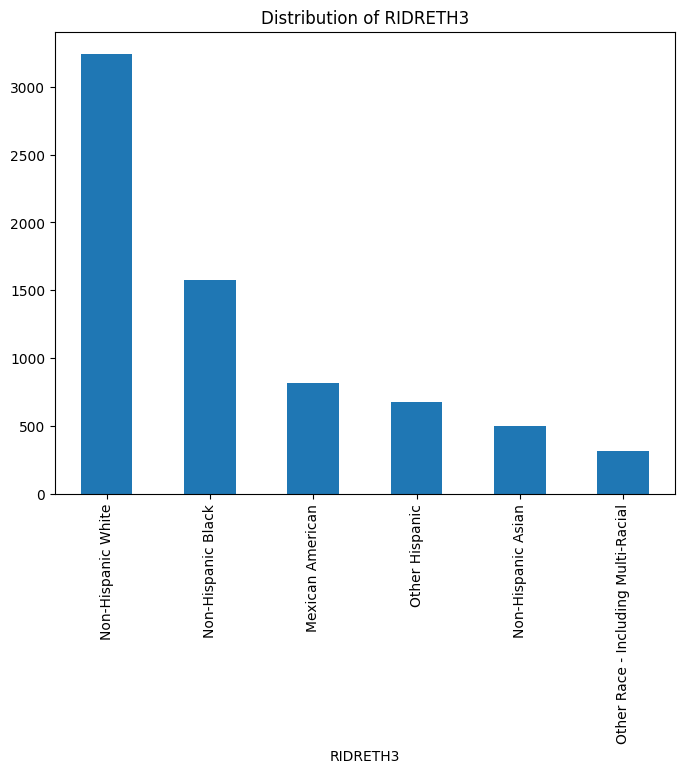

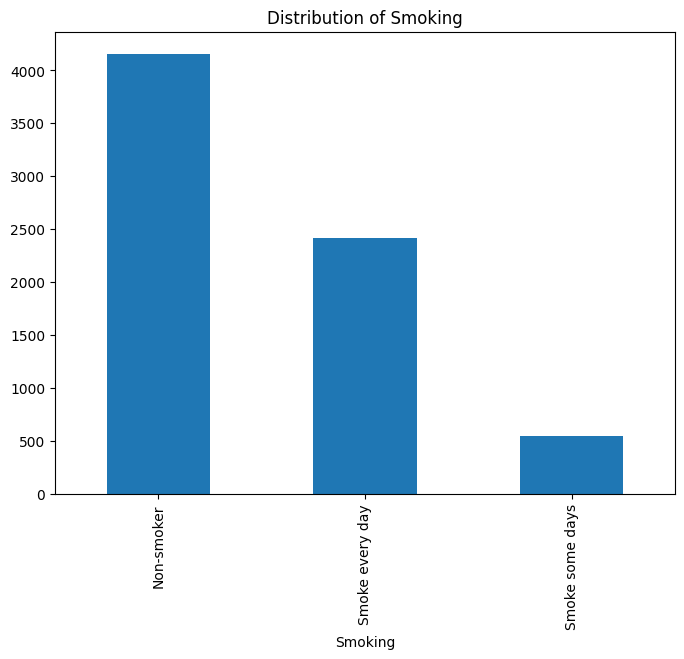

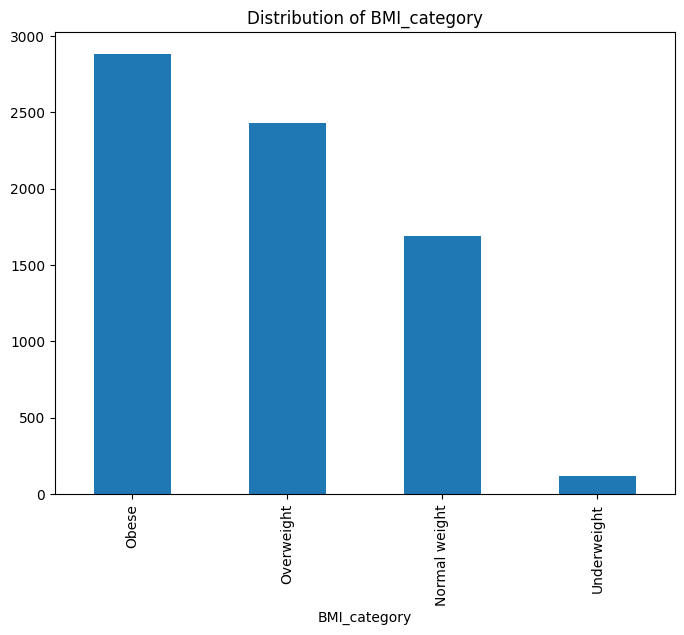

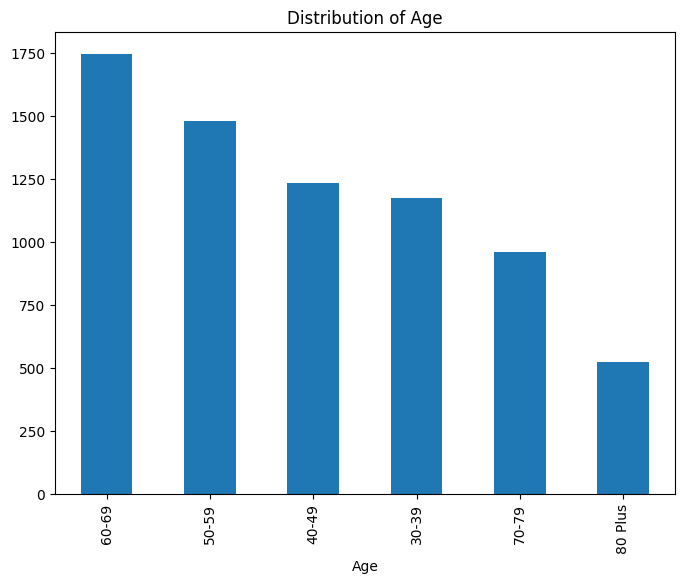

In [6]:
#Prepare bar charts for the categorical variables
for col in cat_cols:
    plt.figure(figsize=(8, 6))
    df[col].value_counts().plot(kind="bar")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)

<Figure size 800x600 with 0 Axes>

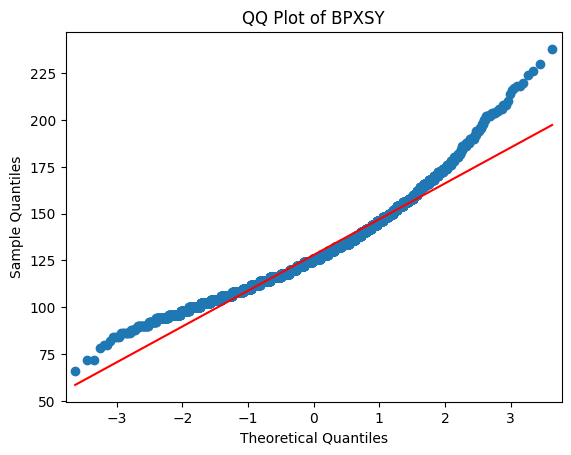

<Figure size 800x600 with 0 Axes>

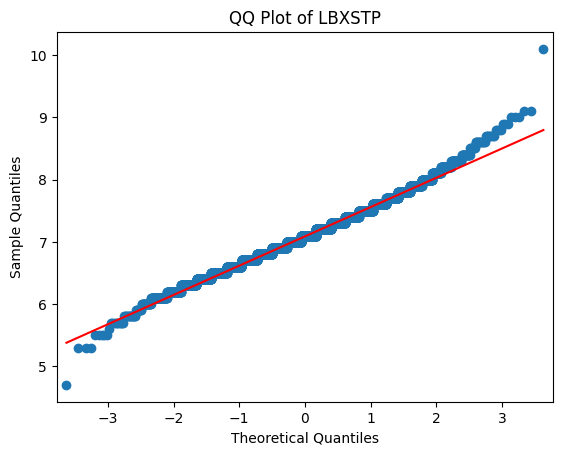

In [7]:
#Prepare QQ plots for the numerical variables
import statsmodels.api as sm
for col in num_cols:
    plt.figure(figsize=(8, 6))
    sm.qqplot(df[col], line="s")
    plt.title(f"QQ Plot of {col}")

In [8]:
#Obtain statistics for the numerical variables
df[num_cols].describe()


,BPXSY,LBXSTP
count,7119.000000,7119.000000
mean,127.929484,7.086993
std,19.118295,0.470560
min,66.000000,4.700000
25%,114.000000,6.800000
50%,126.000000,7.100000
75%,138.000000,7.400000
max,238.000000,10.100000


/tmp/ipython-input-9-2922054980.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(col)["LBXSTP"].median().plot(kind="bar")
/tmp/ipython-input-9-2922054980.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(col)["LBXSTP"].median().plot(kind="bar")
/tmp/ipython-input-9-2922054980.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(col)["LBXSTP"].median().plot(kind="bar")


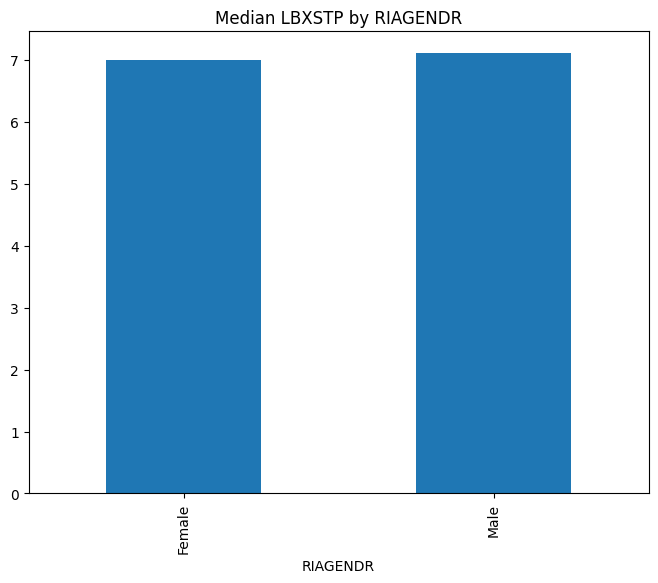

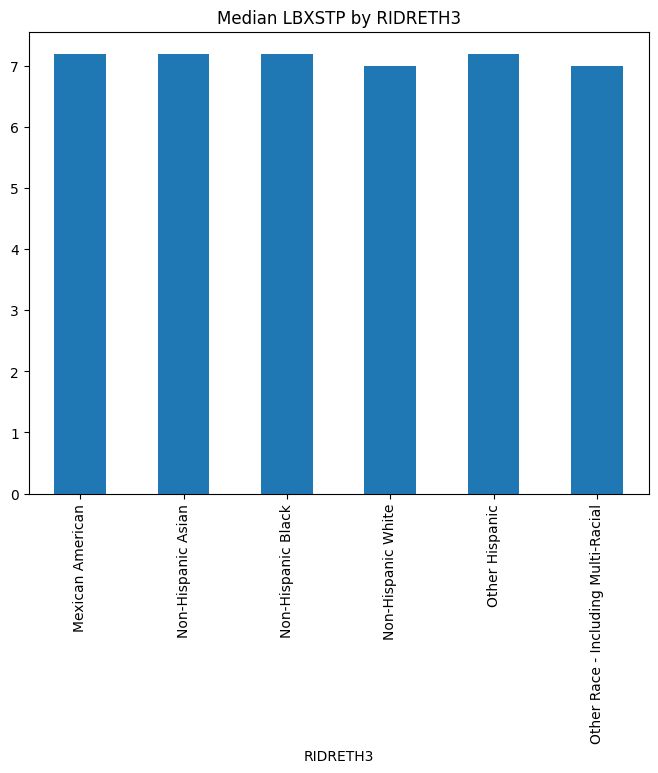

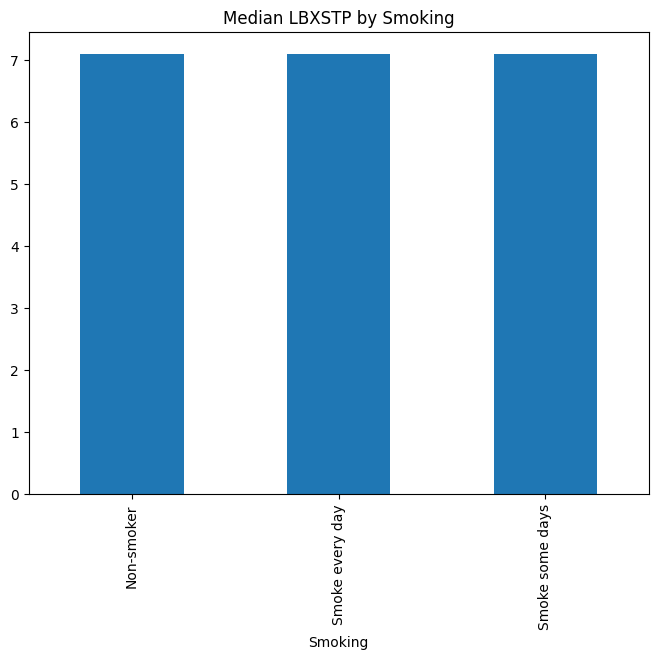

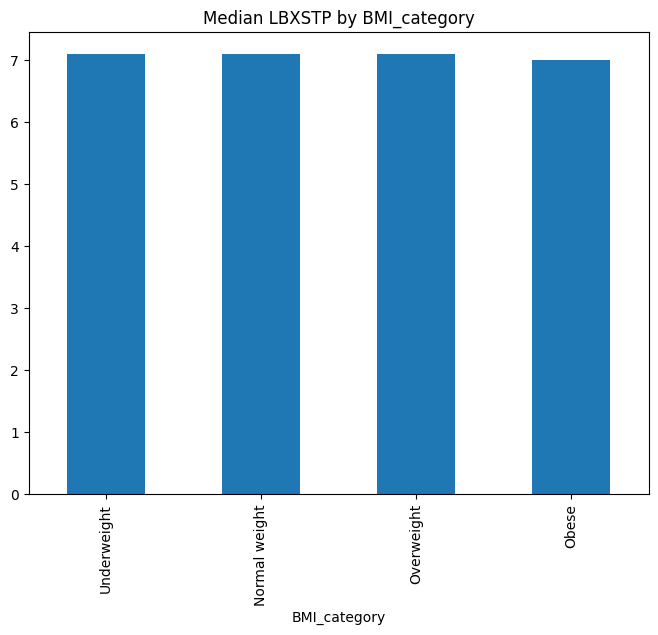

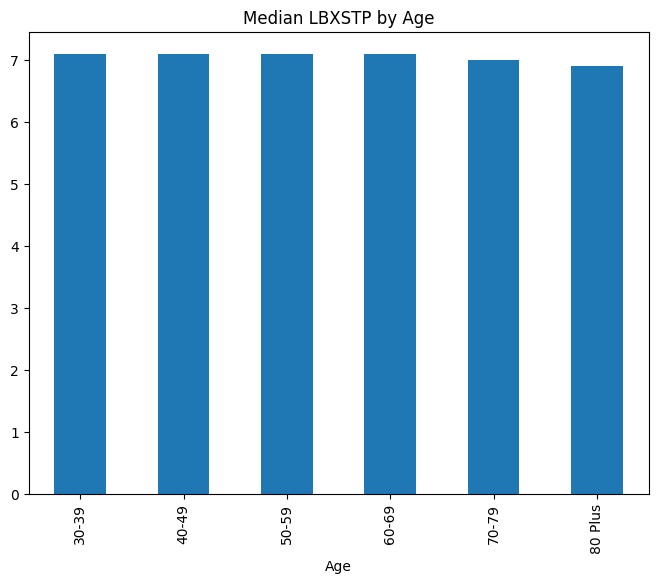

In [9]:
#Create bar charts showing median Creatinine levels against each category of  categorical variable
for col in cat_cols:
    plt.figure(figsize=(8, 6))
    df.groupby(col)["LBXSTP"].median().plot(kind="bar")
    plt.title(f"Median LBXSTP by {col}")

In [10]:
#Use getdummies
#Create 0 and 1s for the categorical columns (for linear regression)
#Drop the first column for the dummy columns - later you will need to compare against the first column
df = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype=int)


display(df)

,LBXSTP,BPXSY,RIAGENDR_Male,RIDRETH3_Non-Hispanic Asian,RIDRETH3_Non-Hispanic Black,RIDRETH3_Non-Hispanic White,RIDRETH3_Other Hispanic,RIDRETH3_Other Race - Including Multi-Racial,Smoking_Smoke every day,Smoking_Smoke some days,BMI_category_Normal weight,BMI_category_Overweight,BMI_category_Obese,Age_40-49,Age_50-59,Age_60-69,Age_70-79,Age_80 Plus
7376,7.6,102.0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0
7379,7.0,144.0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0
7392,8.2,112.0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
7403,6.7,134.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
7413,7.7,124.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34034,7.7,152.0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
34035,7.1,88.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
34036,7.3,122.0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0
34038,7.5,122.0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0


In [11]:
x = df.drop(columns=["LBXSTP"])
y = df["LBXSTP"]

In [12]:
#Linear regression using OLS
model = sm.OLS(y, sm.add_constant(x))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 LBXSTP   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     37.95
Date:                Wed, 23 Jul 2025   Prob (F-statistic):          2.03e-120
Time:                        06:13:23   Log-Likelihood:                -4424.9
No. Observations:                7119   AIC:                             8886.
Df Residuals:                    7101   BIC:                             9009.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------



# 🧪 Analysis of the Relationship Between Total Protein (LBXSTP) and Various Factors

## **Overview**

A multiple linear regression was ran to explore how **BMI category, age, race, smoking status, gender, and systolic blood pressure (BPXSY)** predict **total protein levels (LBXSTP)** in a dataset of **7,119 participants**.

---

## **Model Summary**

| Statistic                 | Value    |
| ------------------------- | -------- |
| **R-squared**             | 0.083    |
| **Adjusted R-squared**    | 0.081    |
| **F-statistic**           | 37.95    |
| **p-value (F-statistic)** | < 0.0001 |
| **Observations**          | 7,119    |

### **Interpretation:**

* **R-squared = 0.083**
  → The model explains **8.3%** of the variance in total protein levels.
  Most of the variability in total protein is due to factors not included in this model.

* **Model is statistically significant** (p < 0.0001)
  → At least one predictor has a significant association with total protein.

---

## **Significant Predictors**

| Predictor                    | Coefficient | p-value | Interpretation                                                                                                           |
| ---------------------------- | ----------- | ------- | ------------------------------------------------------------------------------------------------------------------------ |
| **Systolic BP (BPXSY)**      | +0.0022     | <0.001  | Higher BP is associated with a **slight increase** in total protein.                                                     |
| **Gender (Male)**            | +0.0803     | <0.001  | Males have **higher total protein** than females, on average.                                                            |
| **Non-Hispanic Black**       | +0.0744     | <0.001  | Non-Hispanic Black individuals tend to have **higher total protein** compared to the reference group (Mexican American). |
| **Non-Hispanic White**       | -0.1620     | <0.001  | Non-Hispanic White individuals tend to have **lower total protein**.                                                     |
| **Other Race / Multiracial** | -0.1100     | <0.001  | Lower total protein compared to Mexican Americans.                                                                       |
| **Smoking (Every day)**      | -0.0466     | <0.001  | Daily smokers tend to have **lower total protein**.                                                                      |
| **BMI (Obese)**              | -0.1105     | 0.010   | Obesity is associated with **lower total protein**.                                                                      |
| **Age 40-49**                | -0.0539     | 0.004   | Slight **decrease** in total protein compared to the reference group (20-39).                                            |
| **Age 50-59**                | -0.0556     | 0.002   | Slight **decrease** in total protein compared to the reference group (20-39).                                                                                                     |
| **Age 60-69**                | -0.1030     | <0.001  | Greater **decrease** in total protein compared to the reference group (20-39).                                                                                       |
| **Age 70-79**                | -0.1535     | <0.001  | Even greater **decrease** in total protein compared to the reference group (20-39).                                                                                                    |
| **Age 80+**                  | -0.2450     | <0.001  | Largest decrease in total protein with age.                                                                              |

---

## **Non-Significant Predictors**

| Predictor                        | p-value | Interpretation                 |
| -------------------------------- | ------- | ------------------------------ |
| Non-Hispanic Asian               | 0.821   | No significant effect.         |
| Other Hispanic                   | 0.941   | No significant effect.         |
| Smoking (Some days)              | 0.881   | No significant effect.         |
| BMI (Normal weight / Overweight) | \~0.145 | No significant effect. |

---

## **Model Diagnostics**

* **Durbin-Watson: 2.008**
  → No major autocorrelation problem. ✅

* **Condition Number: 2,140**
  → ⚠️ **Potential multicollinearity issue**. Large condition numbers (>1000) often suggest correlated predictors.
  *Tip: Consider checking VIF (Variance Inflation Factor) to confirm.*

* **Omnibus & Jarque-Bera Tests: Significant**
  → Residuals are **not perfectly normally distributed**, but in large samples (n > 5,000) this is often tolerable.

---

## **Key Takeaways**

* **Gender, race, systolic BP, obesity, smoking, and age** are significantly associated with total protein.
* **Protein levels tend to decrease with age** and **are lower in obese individuals**.
* **Daily smoking is linked to reduced protein**, but "some day smokers" showed no significant difference.
* **Non-Hispanic Whites and Multiracial participants** tend to have **lower protein levels**, while **Non-Hispanic Blacks have higher levels**.

